## Start data cleaning process

In [1]:
import pandas as pd
import numpy as np
import networkx as nx
from sklearn.preprocessing import StandardScaler, normalize, MinMaxScaler
import matplotlib.pyplot as plt
from collections import defaultdict, Counter
import urllib.request as request
import json
import os
from scipy.sparse import csr_matrix as csr_matrix 
from matplotlib import cm
import numpy as np
from sklearn import cluster
from tempfile import TemporaryFile
import  torch
import torch_geometric

In [2]:
#url = "https://api.tradestatistics.io/yrpc?y=2017&r=usa&p=all&l=4"
comtradeurl = './data/comtrade_data/'

In [3]:
import numpy as np
# Save
# Save names to npy dict 
#np.save('countries_rename.npy', replace_dict) 
replace_dict = np.load('./data/countries_rename.npy', allow_pickle=True).item() # Get dict items from npy file

In [4]:
## Replace function to rename countries for uniformity
def replace_(country_list, replace_dict):
    nnn = country_list.copy()
         #nnn[i] = a.replace('&','and')
    for k, v in replace_dict.items():
        for i,a in enumerate(nnn):
            if a == k:
                nnn[i] = v

    return nnn

In [20]:

# trade_data = trade_data[['export_value_usd','import_value_usd','partner_iso','product_code', 'product_code_length', 'reporter_iso']]
# trade_data.head()

## Read data of countries import and exports with partner countries from directory
dataurl = './data/'


frames =[]
for name in os.listdir(comtradeurl):
    a = pd.read_csv(comtradeurl+name)
    a = a[['Trade Flow','Reporter','Partner','Trade Value (US$)']]
    frames.append(a)

trade = pd.concat(frames, ignore_index=True)
trade = trade.dropna()

print('\n',trade.head(10))
print('\nPrint columns having NaNs', trade[trade['Trade Flow'].isna() == True]) 
print('\n',trade.isna().sum()) # Counts NaNs if there are any


   Trade Flow   Reporter   Partner  Trade Value (US$)
0     Import    Albania  Zimbabwe            11278.0
1     Export    Albania     Yemen             4797.0
2     Import    Algeria  Zimbabwe           690773.0
3     Export    Algeria  Zimbabwe               72.0
4     Import    Algeria     Yemen              883.0
5     Export    Algeria     Yemen           232446.0
6     Import    Algeria    Zambia           455658.0
7     Export    Andorra     Yemen              120.0
8     Import  Australia  Zimbabwe           430385.0
9     Export  Australia  Zimbabwe          1072517.0

Print columns having NaNs Empty DataFrame
Columns: [Trade Flow, Reporter, Partner, Trade Value (US$)]
Index: []

 Trade Flow           0
Reporter             0
Partner              0
Trade Value (US$)    0
dtype: int64


In [21]:
HCI_data = pd.read_csv(dataurl+'HCIcountry.csv')
c_income_group = HCI_data[['Short Name','Income Group']]
c_income_group = c_income_group.rename(columns = {'Short Name': 'country'})
inc_levels = set(c_income_group['Income Group'])
print('Income Levels: \n', list(inc_levels))


inc_levels_dict = {i:j for j,i in enumerate(inc_levels)}
print('\n\nIncome level dictionary: \n', inc_levels_dict)
print('\n\nIncome level table: \n', c_income_group.head())

Income Levels: 
 ['High income', 'Low income', 'Upper middle income', 'Lower middle income']


Income level dictionary: 
 {'High income': 0, 'Low income': 1, 'Upper middle income': 2, 'Lower middle income': 3}


Income level table: 
                 country         Income Group
0           Afghanistan           Low income
1                Angola  Lower middle income
2               Albania  Upper middle income
3  United Arab Emirates          High income
4             Argentina          High income


In [22]:
countries_attributes = pd.read_csv(dataurl+"country_profile_variables2017.csv")
countries_attributes = countries_attributes.replace(['~0','~0.0','-~0.0','...'],0)
countries_attributes = countries_attributes.apply(lambda x: pd.to_numeric(x, errors = 'ignore'))
# Create feature dictionary for easy selection
feature_indices_dict = {i:j for i,j in enumerate(list(countries_attributes.columns))}
#print(feature_indices_dict)
countries_attributes.iloc[:,2:] = countries_attributes.iloc[:,2:].select_dtypes(exclude = 'object')
#b = list(map(feature_indices_dict.get,[1,2,3,4])) select relevant  features for learning here
# countries_profile = countries_profile[b]
countries_attributes = countries_attributes.dropna(axis = 'columns')
#countries_profile = countries_profile.drop_duplicates(subset = 'country', inplace = True)
countries_attributes = countries_attributes.drop(['Region'], axis = 1)
countries_attributes.head()

,country,Surface area (km2),Population in thousands (2017),"Population density (per km2, 2017)","Sex ratio (m per 100 f, 2017)",GDP: Gross domestic product (million current US$),"GDP growth rate (annual %, const. 2005 prices)",GDP per capita (current US$),Economy: Agriculture (% of GVA),Economy: Industry (% of GVA),...,Education: Government expenditure (% of GDP),Seats held by women in national parliaments %,Mobile-cellular subscriptions (per 100 inhabitants),Mobile-cellular subscriptions (per 100 inhabitants).1,Individuals using the Internet (per 100 inhabitants),Threatened species (number),CO2 emission estimates (million tons/tons per capita),"Energy production, primary (Petajoules)","Pop. using improved sanitation facilities (urban/rural, %)",Net Official Development Assist. received (% of GNI)
0,Afghanistan,652864,35530,54.4,106.3,20270,-2.4,623.2,23.3,23.3,...,3.3,27.7,61.6,8.3,42,2.1,63,5,21.43,-99
1,Albania,28748,2930,106.9,101.9,11541,2.6,3984.2,22.4,26.0,...,3.5,22.9,106.4,63.3,130,28.2,84,36,2.96,-99
2,Algeria,2381741,41318,17.3,102.0,164779,3.8,4154.1,12.2,37.3,...,0.0,31.6,113.0,38.2,135,0.8,5900,55,0.05,-99
3,American Samoa,199,56,278.2,103.6,-99,-99.0,-99.0,-99.0,-99.0,...,-99.0,-99.0,0.0,-99.0,92,87.9,-99,-99,-99.00,-99
4,Andorra,468,77,163.8,102.3,2812,0.8,39896.4,0.5,10.8,...,3.3,32.1,88.1,96.9,13,34.0,1,119,-99.00,-99


In [23]:
# Check if data is numeric and workable
print(countries_attributes.dtypes)

country                                                        object
Surface area (km2)                                              int64
Population in thousands (2017)                                  int64
Population density (per km2, 2017)                            float64
Sex ratio (m per 100 f, 2017)                                 float64
GDP: Gross domestic product (million current US$)               int64
GDP growth rate (annual %, const. 2005 prices)                float64
GDP per capita (current US$)                                  float64
Economy: Agriculture (% of GVA)                               float64
Economy: Industry (% of GVA)                                  float64
Economy: Services and other activity (% of GVA)               float64
Employment: Agriculture (% of employed)                       float64
Employment: Industry (% of employed)                          float64
Employment: Services (% of employed)                          float64
Unemployment (% of l

In [24]:
# countries_profile['International trade: Exports (million US$)'].astype('float')
# pd.to_numeric(countries_profile, errors = 'raise')
#Standardize data
cols = countries_attributes.columns[1:]
scaler = StandardScaler()
scaled_data = scaler.fit_transform(countries_attributes.iloc[:,1:])
scaled_data = pd.DataFrame(scaled_data, columns = cols)
countries_attributes.iloc[:,1:] = scaled_data
countries_attributes.head()

,country,Surface area (km2),Population in thousands (2017),"Population density (per km2, 2017)","Sex ratio (m per 100 f, 2017)",GDP: Gross domestic product (million current US$),"GDP growth rate (annual %, const. 2005 prices)",GDP per capita (current US$),Economy: Agriculture (% of GVA),Economy: Industry (% of GVA),...,Education: Government expenditure (% of GDP),Seats held by women in national parliaments %,Mobile-cellular subscriptions (per 100 inhabitants),Mobile-cellular subscriptions (per 100 inhabitants).1,Individuals using the Internet (per 100 inhabitants),Threatened species (number),CO2 emission estimates (million tons/tons per capita),"Energy production, primary (Petajoules)","Pop. using improved sanitation facilities (urban/rural, %)",Net Official Development Assist. received (% of GNI)
0,Afghanistan,0.037847,0.020854,-0.177549,0.215730,-0.204116,0.149045,-0.583916,0.652345,0.190182,...,0.484623,0.566946,-0.473046,-0.639308,-0.529781,-0.747232,-0.242767,-0.624041,1.083657,0.0
1,Albania,-0.312476,-0.224289,-0.154727,0.060066,-0.210032,0.317795,-0.439915,0.626724,0.260130,...,0.489519,0.461624,0.215832,0.533149,-0.232287,0.021240,-0.240644,-0.368985,0.723607,0.0
2,Algeria,1.008285,0.064378,-0.193677,0.063604,-0.106174,0.358295,-0.432636,0.336348,0.552876,...,0.403853,0.652519,0.317318,-0.001918,-0.215384,-0.785508,0.347352,-0.212660,0.666881,0.0
3,American Samoa,-0.328501,-0.245901,-0.080260,0.120209,-0.217921,-3.111201,-0.614858,-2.829321,-2.978205,...,-2.019264,-2.213100,-1.420253,-2.926664,-0.360750,1.779010,-0.259145,-1.479712,-1.263974,0.0
4,Andorra,-0.328350,-0.245743,-0.129991,0.074217,-0.215948,0.257045,1.098731,0.003269,-0.133651,...,0.484623,0.663490,-0.065563,1.249413,-0.627818,0.192012,-0.249035,0.313907,-1.263974,0.0


### Load and preprocess data for distances between countries 

In [25]:
countries_distances = pd.read_csv(dataurl+"countries_distances.csv")
countries_distances = countries_distances.rename(columns = {'pays1':'country1', 'pays2':'country2'})
countries_distances = countries_distances[['country1','country2','dist']]
countries_names = list(countries_distances['country1'])
countries_distances.head()
# countries_distances['country1'] = replace_(countries_distances['country1'],replace_dict)
# countries_distances['country2'] = replace_(countries_distances['country2'],replace_dict)

,country1,country2,dist
0,Canada,South Africa,11225.350157
1,Canada,Denmark,3963.908725
2,Canada,USSR,1254.420921
3,Canada,Pakistan,7831.515168
4,Canada,Aral Sea,6706.606664


### Replace differing names of countries for uniformity

In [26]:
dat1 = list(countries_attributes['country'])
dat2 = list(c_income_group['country'])
dat3 = list(set(countries_distances['country1']))
dat3_1 = list(countries_distances['country1'])
dat3_2 = list(countries_distances['country2'])

dat1 = replace_(dat1, replace_dict)
dat2 = replace_(dat2, replace_dict)
dat3 = replace_(dat3, replace_dict)
dat3_1  = replace_(dat3_1, replace_dict)

countries_attributes['country'] = dat1
c_income_group['country'] = dat2
countries_distances['country1'] = dat3_1 
countries_distances['country2'] = dat3_2 
countries_attributes = countries_attributes.drop_duplicates(subset = 'country', inplace = False)

In [27]:
print('Number of countries in countries_profile: ', len(countries_attributes))
print('Number of countries in data 2: ', len(c_income_group))
print('Number of countries in data 3: ', len(countries_distances))

Number of countries in countries_profile:  228
Number of countries in data 2:  157
Number of countries in data 3:  34410


In [28]:
# [print(i) for i in c_income_group['country']]
common_countries = []  #Countries found in all three lists of countries
c1_nc23 = [] # countries found in c1 but not in c2 and c3
ncm123 = []
c2_nc13 = [] # countries found in c2 but not in c1 and c3
c3_nc12 = [] # countries found in c3 but not in c1 and c2
for c in dat1:
    if c in dat2 and c in dat3:
        common_countries.append(c)
    else: 
        ncm123.append(c)
        
for c in dat2:
    if c in dat1 and c in dat3:
        pass
    else: 
        c2_nc13.append(c)
        
for c in dat3:
    if c in dat1 and c in dat2:
        pass
    else: 
        c3_nc12.append(c)

print(len(common_countries))

112


In [29]:
## Make a dictionary of countries and their given codes as keys for easy reference

country_dict = {j:i for i, j in enumerate(sorted(set(common_countries)))}
#country_dict

In [30]:
# Select countries with names or data appearing in each of the datasets

countries_attributes = countries_attributes[countries_attributes['country'].isin(common_countries)].reset_index(drop =True)
c_income_group = c_income_group[c_income_group['country'].isin(common_countries)]
countries_dists = countries_distances[countries_distances['country1'].isin(common_countries)]
countries_dists = countries_dists[countries_dists['country2'].isin(common_countries)]

In [31]:
print(len(countries_attributes))
print(len(c_income_group))
print(len(countries_dists))

111
111
12099


## Create a tuple of countries with the distances between them
eg. (country1, country2, distance)

In [32]:
cdist = countries_dists.copy()
edge_list = []
for i in range(len(cdist)):
  
    c = (country_dict[str(cdist.iloc[i,0])], country_dict[str(cdist.iloc[i,1])], 
           round(cdist.iloc[i,2],2))

    edge_list.append(c)
edge_list = sorted(edge_list)
#edge_list

In [33]:
edges_dists = pd.DataFrame(edge_list)

In [34]:
edge_list[:10]

[(0, 1, 3544.01),
 (0, 2, 4703.22),
 (0, 3, 5869.08),
 (0, 4, 13688.78),
 (0, 5, 7642.47),
 (0, 6, 3870.99),
 (0, 7, 1094.63),
 (0, 8, 1770.53),
 (0, 9, 4672.23),
 (0, 10, 6256.24)]

### Process trade import and exports between countries

In [35]:
trade_reporters = list(set(trade['Reporter']))
trade_partners = list(set(trade['Partner']))
flow = list(set(trade['Trade Flow']))
print('Total Number of reporters: ', len(trade_reporters))
print('Total number of partners: ', len(trade_partners))

Total Number of reporters:  146
Total number of partners:  213


In [36]:
flow

['Re-Import', 'Import', 'Export', 'Re-Export']

In [37]:
imports_data = trade[trade['Trade Flow'] == 'Import'].reset_index(drop = True)
reimports_data = trade[trade['Trade Flow'] == 'Re-Import'].reset_index(drop = True)
exports_data = trade[trade['Trade Flow'] == 'Export'].reset_index(drop = True)
reexports_data = trade[trade['Trade Flow'] == 'Re-Export'].reset_index(drop = True)

In [38]:
imports_data.head()

,Trade Flow,Reporter,Partner,Trade Value (US$)
0,Import,Albania,Zimbabwe,11278.0
1,Import,Algeria,Zimbabwe,690773.0
2,Import,Algeria,Yemen,883.0
3,Import,Algeria,Zambia,455658.0
4,Import,Australia,Zimbabwe,430385.0


In [39]:
exports_data.head()

,Trade Flow,Reporter,Partner,Trade Value (US$)
0,Export,Albania,Yemen,4797.0
1,Export,Algeria,Zimbabwe,72.0
2,Export,Algeria,Yemen,232446.0
3,Export,Andorra,Yemen,120.0
4,Export,Australia,Zimbabwe,1072517.0


In [40]:
reimports_data.head()

,Trade Flow,Reporter,Partner,Trade Value (US$)
0,Re-Import,Namibia,Zambia,440697.0
1,Re-Import,Pakistan,Zambia,10016.0
2,Re-Import,Italy,Lithuania,1151943.0
3,Re-Import,Italy,Luxembourg,6301227.0
4,Re-Import,Luxembourg,Lithuania,14638.0


In [41]:
reexports_data.head()

,Trade Flow,Reporter,Partner,Trade Value (US$)
0,Re-Export,Canada,Zimbabwe,449133.0
1,Re-Export,Canada,Yemen,61592.0
2,Re-Export,Canada,Zambia,1487848.0
3,Re-Export,Cyprus,Zambia,189233.0
4,Re-Export,Italy,Zimbabwe,97755.0


In [42]:
imp_partners = imports_data['Partner']
imp_reporters = imports_data['Reporter']
imports_data['Partner'] = replace_(imp_partners, replace_dict)
imports_data['Reporter'] = replace_(imp_reporters, replace_dict)

exp_partners = exports_data['Partner']
exp_reporters = exports_data['Reporter']
exports_data['Partner'] = replace_(exp_partners, replace_dict)
exports_data['Reporter'] = replace_(exp_reporters, replace_dict)

print('\n',imp_partners.tail())
print('\n',imports_data['Partner'].tail())
print('\n',imp_reporters.tail())
print('\n',imports_data['Reporter'].tail())


 23204    Marshall Isds
23205       Mauritania
23206        Mauritius
23207    Marshall Isds
23208        Mauritius
Name: Partner, dtype: object

 23204    Marshall Isds
23205       Mauritania
23206        Mauritius
23207    Marshall Isds
23208        Mauritius
Name: Partner, dtype: object

 23204      Seychelles
23205    Sierra Leone
23206    Sierra Leone
23207    Sierra Leone
23208        Barbados
Name: Reporter, dtype: object

 23204      Seychelles
23205    Sierra Leone
23206    Sierra Leone
23207    Sierra Leone
23208        Barbados
Name: Reporter, dtype: object


In [43]:
i = 0
reps = replace_(trade['Reporter'], replace_dict)
pars = replace_(trade['Partner'], replace_dict)
als = list(reps) + list(pars)
cin = []
cnot =[]
for c in als:
    if c in list(common_countries):
        cin.append(c)
        i +=1
    else:
        cnot.append(c)
        
        
        
# i = 0
# reps = replace_(trade['Reporter'], replace_dict)
# pars = replace_(trade['Partner'], replace_dict)
# als = list(reps) + list(pars)
cin1 = []
cnot1 =[]
for c in list(common_countries):
    if c in als:
        cin1.append(c)
    else:
        cnot1.append(c)

In [44]:
# print(set(cnot))
#country_dict

In [45]:
print(cnot1)

['Chad']


In [46]:
print(common_countries)

['Afghanistan', 'Albania', 'Algeria', 'Angola', 'Argentina', 'Australia', 'Austria', 'Bahrain', 'Bangladesh', 'Belgium', 'Benin', 'Botswana', 'Brazil', 'Bulgaria', 'Burkina Faso', 'Burundi', 'Cambodia', 'Cameroon', 'Canada', 'Chad', 'Chile', 'China', 'Colombia', 'Congo', 'Costa Rica', 'Cyprus', 'Denmark', 'Dominican', 'Ecuador', 'Egypt', 'El Salvador', 'Ethiopia', 'Finland', 'France', 'Guyana', 'Gabon', 'Gambia', 'Germany', 'Ghana', 'Greece', 'Guatemala', 'Guinea', 'Guyana', 'Haiti', 'Honduras', 'Hungary', 'Iceland', 'India', 'Iran', 'Iraq', 'Ireland', 'Israel', 'Italy', 'Jamaica', 'Jordan', 'Kenya', 'Kuwait', 'Laos', 'Lebanon', 'Lesotho', 'Liberia', 'Luxembourg', 'Madagascar', 'Malawi', 'Mali', 'Mauritania', 'Mauritius', 'Mexico', 'Mongolia', 'Morocco', 'Mozambique', 'Myanmar', 'Namibia', 'Nepal', 'Netherlands', 'Nicaragua', 'Niger', 'Nigeria', 'Norway', 'Oman', 'Pakistan', 'Panama', 'Papua New Guinea', 'Paraguay', 'Peru', 'Poland', 'Portugal', 'Qatar', 'Romania', 'Rwanda', 'Saudi Ara

In [47]:
len(cin) 

56570

In [48]:
i = 0
cin = []
cnot =[]
partns = replace_(trade['Partner'], replace_dict)
for c in list(common_countries):
    if c in list(partns):
        cin.append(c)
        i +=1
    else:
        cnot.append(c)

In [49]:
len(cin)

106

In [50]:
imports_data.head()

,Trade Flow,Reporter,Partner,Trade Value (US$)
0,Import,Albania,Zimbabwe,11278.0
1,Import,Algeria,Zimbabwe,690773.0
2,Import,Algeria,Yemen,883.0
3,Import,Algeria,Zambia,455658.0
4,Import,Australia,Zimbabwe,430385.0


In [51]:
imports_data = imports_data[imports_data['Reporter'].isin(common_countries)].reset_index(drop = True)
imports_data = imports_data[imports_data['Partner'].isin(common_countries)].reset_index(drop = True)

exports_data = exports_data[exports_data['Reporter'].isin(common_countries)].reset_index(drop = True)
exports_data = exports_data[exports_data['Partner'].isin(common_countries)].reset_index(drop = True)

reimports_data = reimports_data[reimports_data['Reporter'].isin(common_countries)].reset_index(drop = True)
reimports_data = reimports_data[reimports_data['Partner'].isin(common_countries)].reset_index(drop = True)

reexports_data = reexports_data[reexports_data['Reporter'].isin(common_countries)].reset_index(drop = True)
reexports_data = reexports_data[reexports_data['Partner'].isin(common_countries)].reset_index(drop = True)

In [52]:
imports_data

,Trade Flow,Reporter,Partner,Trade Value (US$)
0,Import,Albania,Zimbabwe,11278.0
1,Import,Algeria,Zimbabwe,690773.0
2,Import,Algeria,Yemen,883.0
3,Import,Algeria,Zambia,455658.0
4,Import,Australia,Zimbabwe,430385.0
5,Import,Australia,Yemen,16665.0
6,Import,Australia,Zambia,491713.0
7,Import,Austria,Zimbabwe,766037.0
8,Import,Austria,Yemen,311104.0
9,Import,Austria,Zambia,253653.0


In [53]:
# Import data between countries into tuples of countries and edges
def make_directed_edges(data, compare_dict):
    data = data.copy()
    edges = []
    for i in range(len(data)):

        c = (compare_dict[str(data.iloc[i,1])], compare_dict[str(data.iloc[i,2])], 
               round(data.iloc[i,3],2))
        edges.append(c)
    #edges = sorted(iedges)
    return edges

In [54]:
def check_cyclic_edges(edge_list, remove_edges = False):
    self_edges = []
    new_edge_list = []
    idx = []
    for i in range(len(edge_list)):
        if (edge_list[i][0] == edge_list[i][1]):
            #print(edge_list[i])
            self_edges.append(edge_list[i])
            idx.append(i)
        else:
            new_edge_list.append(edge_list[i])
    if remove_edges:
        return new_edge_list, self_edges
    else:
        return edge_list, self_edges

In [55]:
# Make edges and remove recurring ones
iedges = make_directed_edges(imports_data, country_dict)
iedges, iself_edges = check_cyclic_edges(iedges, remove_edges=True)

eedges = make_directed_edges(exports_data, country_dict)
eedges, eself_edges = check_cyclic_edges(eedges, remove_edges=True)

In [56]:
# Function to make a dictionary of nodes and attributes
def get_node_attributes(attributes, dict_):
    attr_names = attributes.columns[1:]
    
    attr_dict = {}

    for i in range(len(attributes)):
        attr_dict[dict_[attributes.loc[i][0]]] = {attr_names[j]: k for j, k in enumerate(attributes.loc[i][1:])}
    return attr_dict

/home/kobby/miniconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


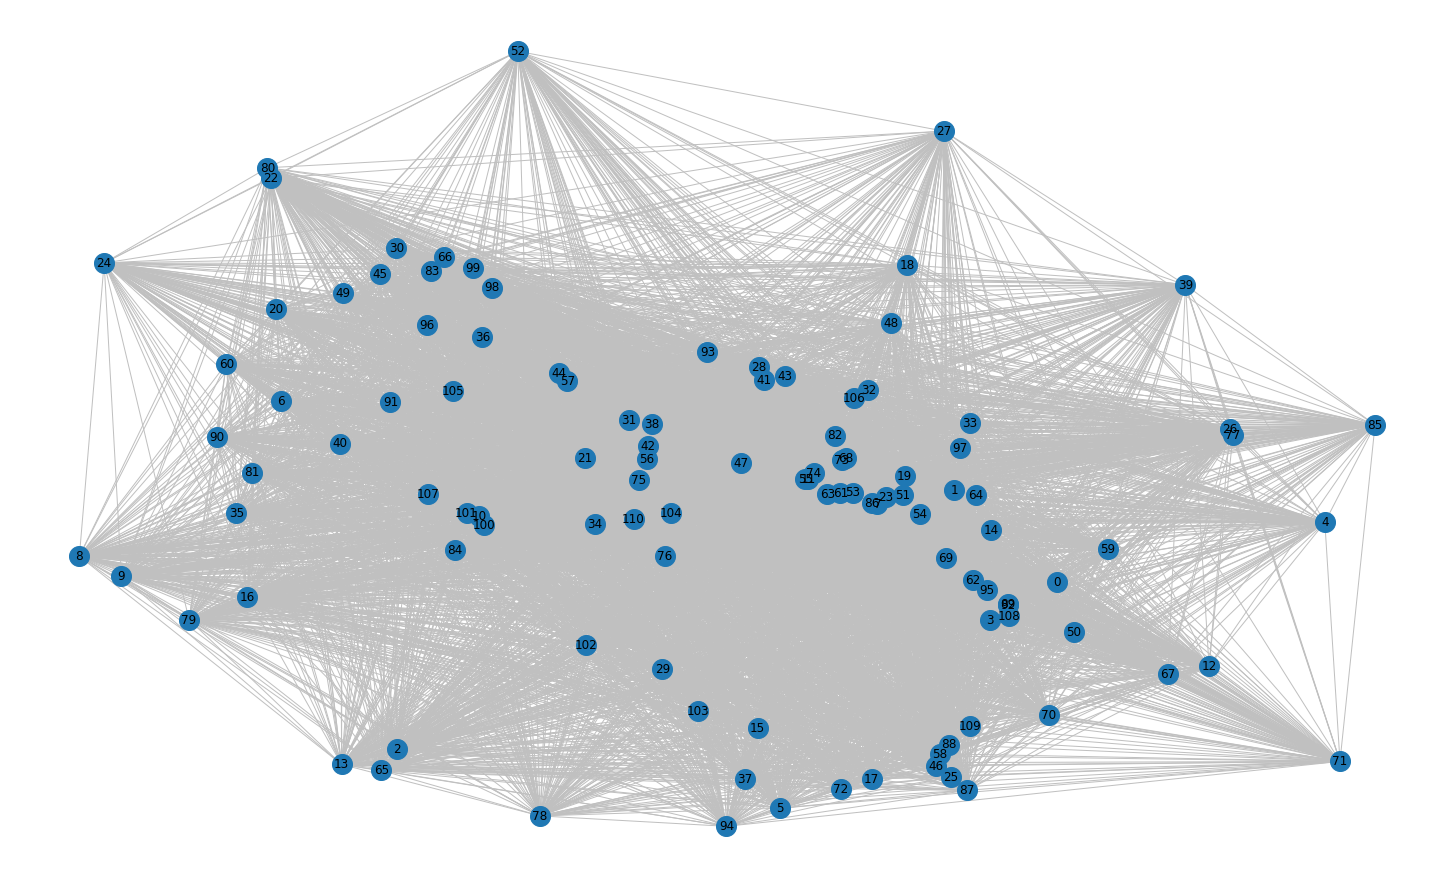

In [72]:
G = nx.Graph()   # Define Graph here
G = G.to_undirected()
G.add_weighted_edges_from(edge_list)
pos=nx.spring_layout(G)
A = nx.adjacency_matrix(G)
A = A.todense()
#attr_names = countries_profile.columns[2:]

attr_dict = get_node_attributes(countries_attributes, country_dict)
#attr_dict = set_node_attributes(scaled_data, attr_names)
nx.set_node_attributes(G, attr_dict)


plt.figure(figsize=(20,12))

nx.draw(G, pos, node_size=400, with_labels=True, edge_color = '#C0C0C0')
plt.savefig('./images/graph_raw')
plt.show()

In [73]:
c_income_group.columns

Index(['country', 'Income Group'], dtype='object')

In [74]:
def income_level_dict(income_grp, country_dict_):
    groups = income_grp.iloc[:,1]
    classes = list(set(groups))
    c_dict = {}
    for c in classes:
        l = income_grp[groups== c].iloc[:,0]
        c_dict[c] = [country_dict[a] for a in l]
    return c_dict

In [75]:
# cdict = income_level_dict(c_income_group, country_dict)
il_dict = income_level_dict(c_income_group, country_dict)
print(il_dict)

{'High income': [104, 4, 5, 6, 9, 7, 18, 97, 20, 25, 36, 26, 93, 32, 33, 38, 44, 49, 45, 50, 51, 55, 60, 73, 77, 78, 80, 84, 85, 86, 89, 96, 106, 105], 'Low income': [0, 15, 10, 14, 31, 40, 35, 42, 59, 61, 63, 69, 62, 75, 72, 88, 90, 91, 19, 100, 98, 103, 108, 110], 'Upper middle income': [1, 13, 12, 11, 21, 22, 24, 27, 2, 28, 34, 39, 41, 47, 48, 52, 53, 57, 66, 65, 71, 83, 82, 87, 99, 102, 92], 'Lower middle income': [3, 8, 17, 23, 29, 37, 43, 46, 54, 16, 56, 94, 58, 68, 70, 67, 64, 76, 74, 79, 81, 95, 30, 101, 107, 109]}


In [79]:
def draw_network_graph(G, class_dict = None, node_size = 300, color_by_class = False):
    if color_by_class and class_dict != None:
        plt.figure(figsize=(20,12))
        pos = nx.spring_layout(G)
        norm = cm.colors.Normalize(vmin=0, vmax=len(il_dict.keys()))
        color_dict = {j:i for i,j in enumerate(il_dict.keys())}
        for inc_, members in il_dict.items():
            nx.draw_networkx_nodes(G,  pos,
                                     nodelist = members,
                                     node_color=cm.jet(norm(color_dict[inc_])),
                                     node_size=300,
                                     alpha=0.8,
                                     with_labels=True)

          # Draw edges (social connections) and show final plot
            plt.title("Countries and income levels")
            nx.draw_networkx_edges(G, pos, alpha=0.5, edge_color = '#C0C0C0')
        plt.savefig('graph_with_colorlabels')
            
    else:
        plt.figure(figsize=(20,12))
        nx.draw(G, pos, node_size = node_size, with_labels=True, edge_color = '#C0C0C0')
        plt.savefig('./images/graph_with_nocolorlabels')
    plt.title('Graph of Countries with colors corresponding to income groups')
    plt.show()

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

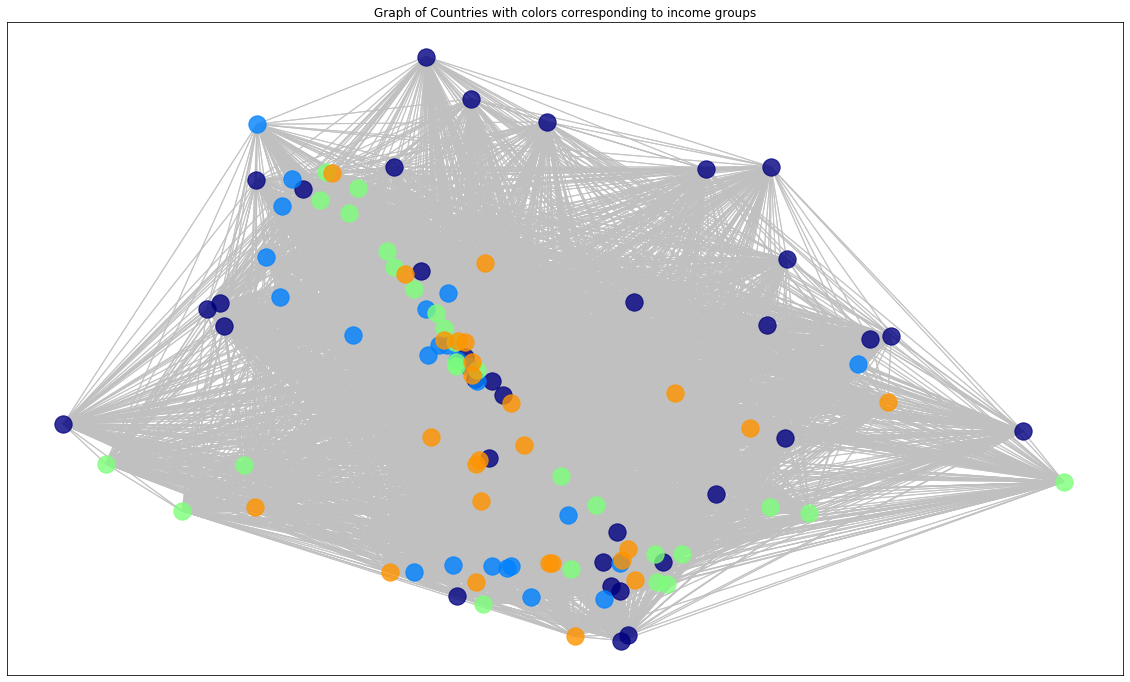

In [80]:
il_dict = income_level_dict(c_income_group, country_dict)
draw_network_graph(G, il_dict, color_by_class = True)

In [81]:
inc = c_income_group.sort_values(by = ['country'])
labels = list(map(inc_levels_dict.get,inc['Income Group']))
data = countries_attributes.sort_values(by = ['country'])

attr_names = data.iloc[:,1:].columns
attr_data = data.iloc[:,1:].values
attr_shape = attr_data.shape
class_names = list(inc_levels)

In [82]:
isrc, itar, iwei = zip(*iedges)  # Unzip import edges
esrc, etar, ewei = zip(*eedges)  # Unzip export edges
dsrc, dtar, dwei = zip(*edge_list) #Unzip distance edges

imat = csr_matrix((iwei,(isrc, itar))).todense()
emat = csr_matrix((ewei,(esrc, etar))).todense()
sparse_adj_dists = csr_matrix((dwei,(dsrc, dtar))) # Make sparse adjacency matrix for distances

tmat = imat - emat # Trade balance incidence matrix
sparse_adj_trade = csr_matrix(tmat) # Make sparse adjacency matrix for trade balance


In [83]:
trade_savez_files = TemporaryFile()
saver = np.savez("./data/trade_savez_files", attr_data = attr_data, attr_shape = attr_shape,
         sparse_adj_trade = sparse_adj_trade, sparse_adj_dists = sparse_adj_dists, labels = labels, class_names = class_names)